# Step #1: Explore and prep data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, roc_auc_score

In [2]:
# Load data
crashes = pd.read_csv('data/Traffic_Crashes_-_Crashes_20250217.csv', low_memory=False)
vehicles = pd.read_csv('data/Traffic_Crashes_-_Vehicles_20250217.csv', low_memory=False)
people = pd.read_csv('data/Traffic_Crashes_-_People_20250217.csv', low_memory=False)

In [3]:
merged = crashes.merge(vehicles, on='CRASH_RECORD_ID', how='left')
data = merged.merge(people, on=['CRASH_RECORD_ID', 'VEHICLE_ID'], how='left')

In [4]:
data.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE_x,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,00a530520c84927490b597a6220ff3f2a3347472ef3086...,NaN,01/15/2025 01:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,RAMP,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,204c3ca48ff3cdf0737e7f10b54ef5f8c49fbe30b5e53e...,NaN,12/04/2024 05:39:00 PM,30,UNKNOWN,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,NaN,FAILED TO YIELD,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,204c3ca48ff3cdf0737e7f10b54ef5f8c49fbe30b5e53e...,NaN,12/04/2024 05:39:00 PM,30,UNKNOWN,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,NaN,NONE,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,0173d218723a1d608d77b7142ca9b9a4afd7463e824162...,Y,09/23/2023 10:39:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,UNKNOWN,PARKED MOTOR VEHICLE,NOT DIVIDED,...,NaN,DISREGARDED CONTROL DEVICES,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,0173d218723a1d608d77b7142ca9b9a4afd7463e824162...,Y,09/23/2023 10:39:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,UNKNOWN,PARKED MOTOR VEHICLE,NOT DIVIDED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266243 entries, 0 to 2266242
Columns: 145 entries, CRASH_RECORD_ID to CELL_PHONE_USE
dtypes: float64(23), int64(8), object(114)
memory usage: 2.4+ GB


In [6]:
data.drop(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'LANE_CNT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'PERSON_ID', 'PERSON_TYPE', 'VEHICLE_ID',
       'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE', 'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH',
       'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'VEHICLE_CONFIG',
       'CARGO_BODY_TYPE', 'LOAD_TYPE', 'HAZMAT_OUT_OF_SERVICE_I',
       'MCS_OUT_OF_SERVICE_I', 'HAZMAT_CLASS', 'CRASH_UNIT_ID', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'CRASH_DATE_x',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'CRASH_DATE_y'],axis=1, inplace=True)

In [7]:
data = data.fillna({
    'AGE': data['AGE'].mean(),
    'MANEUVER': 'UNKNOWN',
    'SEX': 'UNKNOWN'
})

data.isnull().sum()

POSTED_SPEED_LIMIT         0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
MANEUVER                   0
SEX                        0
AGE                        0
dtype: int64

In [8]:
input_cols = ['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'CRASH_DAY_OF_WEEK',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_MONTH', 'MANEUVER', 'SEX', 'AGE']
output_col = ['FIRST_CRASH_TYPE']

# Label-encode ONLY THE TARGET VARIABLE
y = data[output_col]
label_encoder = {}
le = LabelEncoder()
y_encoded = le.fit_transform(y.values.ravel())


In [9]:
# Split data into train and test sets
X = data[input_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=8)

In [10]:
# Reset indexes to ensure alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Step #2: Build a pipeline of training

In [11]:
# Identify categorical columns (original string/object columns)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

In [12]:
# XGBoost pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(random_state=8))
])

# Step #3: Set up hyperparameter tuning

In [13]:
# Hyperparameter tuning
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}


# Create custom scorer parameter
roc_auc_scorer = make_scorer(
    roc_auc_score,
    multi_class='ovr',
    response_method='predict_proba'
)

# Update BayesSearchCV
opt = BayesSearchCV(model, search_space, cv=3, n_iter=10, scoring=roc_auc_scorer, random_state=8)


# Step #4: Train the XGBoost model

In [14]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('cat',
                                                                          TargetEncoder(),
                                                                          ['WEATHER_CONDITION',
                                                                           'LIGHTING_CONDITION',
                                                                           'TRAFFICWAY_TYPE',
                                                                           'ALIGNMENT',
                                                                           'ROADWAY_SURFACE_COND',
                                                                           'ROAD_DEFECT',
                                                                           'PRIM_CONTRIBUTORY_CAUSE',
                                                                           'SEC_CONTRIBUTORY_CAUSE',
                                                                           'MANEUVER',
                                                                           'SEX']),
                                                                         ('num',
                                                                          StandardScaler(),
                                                                          ['POSTED_SPEED_LIMIT',
                                                                           'CRASH_DA...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

# Step #5: Evaluate the model and make predictions

In [15]:
opt.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE',
                                                   'MANEUVER', 'SEX']),
                                                 ('num', StandardScaler(),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_HOUR', 'CRAS...
                               gamma=8.289497472648083, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.4299244814327041, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [16]:
opt.best_score_

0.8878775002343574

In [17]:
opt.score(X_test, y_test)

0.8927011348327513

In [18]:
opt.predict(X_test)

array([10, 10,  7, ..., 10, 10, 10])

In [19]:
opt.predict_proba(X_test)

array([[3.60730314e-03, 1.76702488e-05, 1.84882374e-04, ...,
        1.49065377e-02, 6.01467764e-06, 7.41660735e-03],
       [1.60535306e-01, 2.52812111e-04, 1.99809466e-02, ...,
        2.20716968e-01, 4.94840751e-05, 1.23705894e-01],
       [4.01965156e-03, 3.31187439e-05, 2.76454771e-03, ...,
        6.72881817e-03, 5.55811948e-06, 1.74821960e-03],
       ...,
       [1.27294302e-01, 3.55730794e-04, 2.12231521e-02, ...,
        2.65054017e-01, 4.96302418e-05, 9.46754739e-02],
       [5.43939769e-02, 3.34412529e-04, 7.72634298e-02, ...,
        1.54628024e-01, 7.37828159e-05, 4.97122742e-02],
       [3.94888259e-02, 1.20351207e-04, 5.53062558e-03, ...,
        6.11859933e-02, 3.87595646e-05, 5.26827089e-02]], dtype=float32)

# Step #6: Measure feature importance (optional)

In [20]:
opt.best_estimator_.steps

[('preprocessor',
  ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                   ['WEATHER_CONDITION', 'LIGHTING_CONDITION',
                                    'TRAFFICWAY_TYPE', 'ALIGNMENT',
                                    'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
                                    'PRIM_CONTRIBUTORY_CAUSE',
                                    'SEC_CONTRIBUTORY_CAUSE', 'MANEUVER',
                                    'SEX']),
                                  ('num', StandardScaler(),
                                   ['POSTED_SPEED_LIMIT', 'CRASH_DAY_OF_WEEK',
                                    'CRASH_HOUR', 'CRASH_MONTH', 'AGE'])])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.7750018497221565,
                colsample_bynode=0.5614437441596264,
                colsample_bytree=0.9126202065825759, device=None,
                early_stopping_rounds=None, enable_categor

In [21]:
opt.best_estimator_.steps[1]

('clf',
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.7750018497221565,
               colsample_bynode=0.5614437441596264,
               colsample_bytree=0.9126202065825759, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, feature_weights=None,
               gamma=8.289497472648083, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.4299244814327041,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...))

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

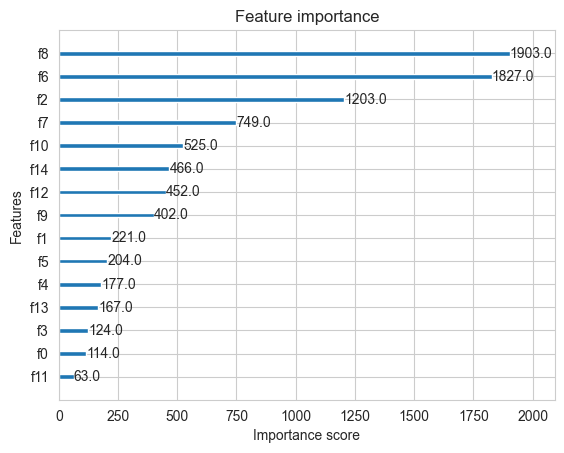

In [22]:
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

In [23]:
dump(opt, 'XGBdump.joblib')
model = load('XGBdump.joblib')

In [24]:
y_pred = opt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(acc * 100, 2)}%")

Accuracy: 65.92%


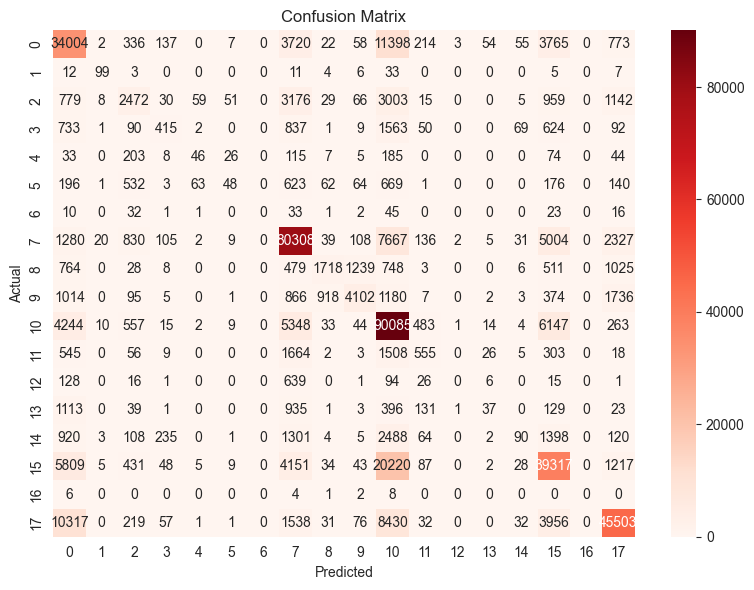

In [25]:
y_true = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()
cm = confusion_matrix(y_test, y_pred)
class_labels = [str(lbl) for lbl in np.unique(np.concatenate((y_true, y_pred)))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.62      0.58     54548
           1       0.66      0.55      0.60       180
           2       0.41      0.21      0.28     11794
           3       0.38      0.09      0.15      4486
           4       0.25      0.06      0.10       746
           5       0.30      0.02      0.04      2578
           6       0.00      0.00      0.00       164
           7       0.76      0.82      0.79     97873
           8       0.59      0.26      0.36      6529
           9       0.70      0.40      0.51     10303
          10       0.60      0.84      0.70    107259
          11       0.31      0.12      0.17      4694
          12       0.00      0.00      0.00       927
          13       0.25      0.01      0.03      2809
          14       0.27      0.01      0.03      6739
          15       0.63      0.55      0.59     71406
          16       0.00      0.00      0.00        21
          17       0.84    

/Users/oyaps/PycharmProjects/crashPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oyaps/PycharmProjects/crashPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oyaps/PycharmProjects/crashPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [27]:
def custom_predict(new_sample):

    new_df = pd.DataFrame([new_sample])
    processed_sample = opt.best_estimator_.named_steps['preprocessor'].transform(new_df)
    prediction = opt.best_estimator_.named_steps['clf'].predict(processed_sample)
    return le.inverse_transform(prediction)[0]

In [28]:
# Sample input
new_sample = {
    'POSTED_SPEED_LIMIT': 40,
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'FOUR WAY',
    'ALIGNMENT': 'STRAIGHT AND LEVEL',
    'CRASH_DAY_OF_WEEK': 7,
    'ROADWAY_SURFACE_COND': 'DRY',
    'ROAD_DEFECT': 'UNKNOWN',
    'PRIM_CONTRIBUTORY_CAUSE': 'FAILING TO REDUCE SPEED TO AVOID CRASH',
    'SEC_CONTRIBUTORY_CAUSE': 'DISTRACTION - FROM INSIDE VEHICLE',
    'CRASH_HOUR': 17,
    'CRASH_MONTH': 4,
    'MANEUVER': 'PARKED',
    'SEX': 'M',
    'AGE': 26.0
}

print(f"Predicted Crash Type: {custom_predict(new_sample)}")

Predicted Crash Type: PARKED MOTOR VEHICLE


In [29]:
new_sample = {
    'POSTED_SPEED_LIMIT': 30,
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'FOUR WAY',
    'ALIGNMENT': 'STRAIGHT AND LEVEL',
    'CRASH_DAY_OF_WEEK': 7,
    'ROADWAY_SURFACE_COND': 'DRY',
    'ROAD_DEFECT': 'UNKNOWN',
    'PRIM_CONTRIBUTORY_CAUSE': 'FAILING TO REDUCE SPEED TO AVOID CRASH',
    'SEC_CONTRIBUTORY_CAUSE': 'DISTRACTION - FROM INSIDE VEHICLE',
    'CRASH_HOUR': 12,
    'CRASH_MONTH': 3,
    'MANEUVER': 'CHANGING LANES',
    'SEX': 'M',
    'AGE': 55.0
}

print(f"Predicted Crash Type: {custom_predict(new_sample)}")

Predicted Crash Type: SIDESWIPE SAME DIRECTION


In [30]:
new_sample = {
    'POSTED_SPEED_LIMIT': 25,
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'ONE-WAY',
    'ALIGNMENT': 'STRAIGHT AND LEVEL',
    'CRASH_DAY_OF_WEEK': '5',
    'ROADWAY_SURFACE_COND': 'ICE',
    'ROAD_DEFECT': 'NO DEFECTS',
    'PRIM_CONTRIBUTORY_CAUSE': 'IMPROPER TURNING/NO SIGNAL',
    'SEC_CONTRIBUTORY_CAUSE': 'UNABLE TO DETERMINE',
    'CRASH_HOUR': '7',
    'CRASH_MONTH': '12',
    'MANEUVER': 'SLOW/STOP IN TRAFFIC',
    'SEX': 'F',
    'AGE': '28.0'
}

print(f"Predicted Crash Type: {custom_predict(new_sample)}")

Predicted Crash Type: TURNING


# Applying Recommended Parameters

In [31]:
# XGBoost pipeline
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(base_score=None, booster=None, callbacks=None,
                          colsample_bylevel=0.7750018497221565,
                          colsample_bynode=0.5614437441596264,
                          colsample_bytree=0.9126202065825759, device=None,
                          early_stopping_rounds=None, enable_categorical=False,
                          eval_metric=None, feature_types=None, feature_weights=None,
                          gamma=8.289497472648083, grow_policy=None, importance_type=None,
                          interaction_constraints=None, learning_rate=0.4299244814327041,
                          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                          max_delta_step=None, max_depth=6, max_leaves=None,
                          min_child_weight=None, monotone_constraints=None,
                          multi_strategy=None, n_estimators=None, n_jobs=None,
                          num_parallel_tree=None, random_state=8))
])

In [32]:
model_xgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE',
                                                   'MANEUVER', 'SEX']),
                                                 ('num', StandardScaler(),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_HOUR', 'CRAS...
                               gamma=8.289497472648083, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.4299244814327041, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [33]:
model_xgb.score(X_test,y_test)

0.6608994173180747

In [34]:
X_test.head()

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,ALIGNMENT,CRASH_DAY_OF_WEEK,ROADWAY_SURFACE_COND,ROAD_DEFECT,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,CRASH_HOUR,CRASH_MONTH,MANEUVER,SEX,AGE
0,30,CLEAR,DAYLIGHT,NOT DIVIDED,STRAIGHT AND LEVEL,6,UNKNOWN,UNKNOWN,FOLLOWING TOO CLOSELY,UNABLE TO DETERMINE,12,12,SLOW/STOP IN TRAFFIC,M,37.917615
1,30,CLEAR,DAYLIGHT,NOT DIVIDED,STRAIGHT AND LEVEL,7,DRY,NO DEFECTS,UNABLE TO DETERMINE,UNABLE TO DETERMINE,9,8,STRAIGHT AHEAD,M,3.000000
2,25,CLEAR,DAYLIGHT,ONE-WAY,STRAIGHT AND LEVEL,4,DRY,NO DEFECTS,UNABLE TO DETERMINE,NOT APPLICABLE,17,7,PARKED,UNKNOWN,37.917615
3,30,CLEAR,DAYLIGHT,ONE-WAY,STRAIGHT AND LEVEL,3,DRY,NO DEFECTS,IMPROPER LANE USAGE,IMPROPER OVERTAKING/PASSING,18,11,CHANGING LANES,F,25.000000
4,30,CLEAR,DAYLIGHT,NOT DIVIDED,STRAIGHT AND LEVEL,3,DRY,NO DEFECTS,FAILING TO REDUCE SPEED TO AVOID CRASH,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,16,8,SLOW/STOP IN TRAFFIC,M,65.000000


In [35]:
X_test[:1]

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,ALIGNMENT,CRASH_DAY_OF_WEEK,ROADWAY_SURFACE_COND,ROAD_DEFECT,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,CRASH_HOUR,CRASH_MONTH,MANEUVER,SEX,AGE
0,30,CLEAR,DAYLIGHT,NOT DIVIDED,STRAIGHT AND LEVEL,6,UNKNOWN,UNKNOWN,FOLLOWING TOO CLOSELY,UNABLE TO DETERMINE,12,12,SLOW/STOP IN TRAFFIC,M,37.917615


In [36]:
data.loc[0]

POSTED_SPEED_LIMIT                          30
WEATHER_CONDITION                        CLEAR
LIGHTING_CONDITION                    DAYLIGHT
FIRST_CRASH_TYPE                  FIXED OBJECT
TRAFFICWAY_TYPE                           RAMP
ALIGNMENT                   STRAIGHT AND LEVEL
ROADWAY_SURFACE_COND                       DRY
ROAD_DEFECT                         NO DEFECTS
PRIM_CONTRIBUTORY_CAUSE    UNABLE TO DETERMINE
SEC_CONTRIBUTORY_CAUSE          NOT APPLICABLE
CRASH_HOUR                                  13
CRASH_DAY_OF_WEEK                            4
CRASH_MONTH                                  1
MANEUVER                        STRAIGHT AHEAD
SEX                                          M
AGE                                       55.0
Name: 0, dtype: object

In [37]:
dump(model_xgb, 'XGBmodification.joblib')
model_xgb = load('XGBmodification.joblib')

In [38]:
preds = model_xgb.predict(X_test)
acc_secondary = accuracy_score(y_test, preds)
print(f"Secondary Accuracy: {round(acc_secondary * 100, 2)}%")


Secondary Accuracy: 66.09%


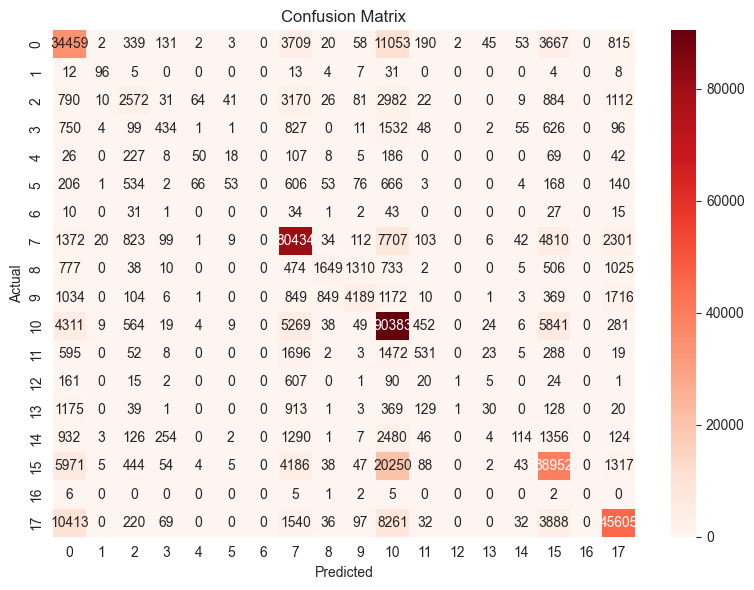

In [39]:
y_true = np.array(y_test).flatten()
preds = np.array(preds).flatten()
cm = confusion_matrix(y_test, preds)
class_labels = [str(lbl) for lbl in np.unique(np.concatenate((y_true, preds)))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [40]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.55      0.63      0.59     54548
           1       0.64      0.53      0.58       180
           2       0.41      0.22      0.29     11794
           3       0.38      0.10      0.15      4486
           4       0.26      0.07      0.11       746
           5       0.38      0.02      0.04      2578
           6       0.00      0.00      0.00       164
           7       0.76      0.82      0.79     97873
           8       0.60      0.25      0.36      6529
           9       0.69      0.41      0.51     10303
          10       0.60      0.84      0.70    107259
          11       0.32      0.11      0.17      4694
          12       0.25      0.00      0.00       927
          13       0.21      0.01      0.02      2809
          14       0.31      0.02      0.03      6739
          15       0.63      0.55      0.59     71406
          16       0.00      0.00      0.00        21
          17       0.83    

/Users/oyaps/PycharmProjects/crashPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oyaps/PycharmProjects/crashPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oyaps/PycharmProjects/crashPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa